In [15]:
from qanta.util import constants as c
from qanta.datasets.quiz_bowl import QuizBowlDataset
qbdb = QuizBowlDataset(1, buzzer_train=True)
questions = qbdb.questions_in_folds(['buzzerdev'])

In [60]:
protobowl_ids = {x.qnum: x.protobowl for x in questions}
print(len(protobowl_ids))

7387


In [30]:
def process_line(x):
    total_time = x['object']['time_elapsed'] + x['object']['time_remaining']
    ratio = x['object']['time_elapsed'] / total_time
    position = int(len(x['object']['question_text'].split()) * ratio)
    return [x['object']['guess'], x['object']['qid'], position, x['object']['ruling']]
data1 = list(map(process_line, data))

In [31]:
import sys
import json
import codecs
import pandas as pd

protobowl_dir = 'data/external/qanta-4may17.log'
data = []
data1 = []
count = 0
with codecs.open(protobowl_dir, 'r', 'utf-8') as f:
    line = f.readline().strip()
    while line is not None:
        while not line.endswith('}}'):
            line += f.readline().strip()
        try:
            line = json.loads(line)
        except ValueError:
            continue
        data.append(line)
        count += 1
        if count % 10000 == 0:
            print('\r\r{}'.format(count))
        data.append(line)
        data1.append(process_line(line))
        line = f.readline().strip()
print(len(data))

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
1390

KeyboardInterrupt: 

In [33]:
len(data1)

3603563

In [106]:
df = pd.DataFrame(data1, columns=['guess', 'qid', 'position', 'result'])
df = df.groupby('qid')

In [35]:
import pickle
pickle.dump(df, open('data/external/protobowl_df.pkl', 'wb'))

In [42]:
buzzes = pickle.load(open('output/buzzer/buzzes_buzzerdev.pkl', 'rb'))

In [45]:
buzzerdev_keys =[x.qnum for x in questions]
list(buzzes.keys())[0] in buzzerdev_keys

True

In [107]:
from qanta.guesser.abstract import AbstractGuesser
from qanta.buzzer import constants as bc
guesses = AbstractGuesser.load_guesses(bc.GUESSES_DIR, folds=['buzzerdev'])
guesses = guesses.groupby('qnum')

In [65]:
from qanta.util.multiprocess import _multiprocess
from qanta.reporting.new_performance import _get_top_guesses
top_guesses = _multiprocess(_get_top_guesses, guesses)

[] done: 7386/7387


In [113]:
from qanta.buzzer.util import GUESSERS
n_guessers = len(GUESSERS)

In [99]:
from qanta.datasets.quiz_bowl import QuestionDatabase
all_questions = QuestionDatabase().all_questions()
answers = {k: v.page for k, v in all_questions.items()}
question_texts = {k: v.text for k, v in all_questions.items()}

In [141]:
position_mapping = dict()
for qnum, guess_list in guesses:
    text = question_texts[qnum]
    guess_list = guess_list.groupby(['sentence', 'token']).groups
    count = 0
    position_mapping[qnum] = []
    for sent in text:
        for word, x in enumerate(text[sent].split()):
            if (sent, word) in guess_list:
                position_mapping[qnum].append(count)
            count += 1
    position_mapping[qnum].append(count)
    assert len(position_mapping[qnum]) == len(guess_list)

In [142]:
from qanta.preprocess import format_guess
import numpy as np

avg_reward = []
for qnum, guess_list in top_guesses.items():
    if qnum not in protobowl_ids:
        continue
    protobowl_id = protobowl_ids[qnum]
    if protobowl_id not in df.groups:
        continue
    buzz = buzzes[qnum]
    answer = answers[qnum]
    buzzing_position = 9999
    buzzing_result = False
    for i in range(len(buzz)):
        choice = np.argmax(buzz[i])
        if choice < n_guessers:
            buzzing_position = position_mapping[qnum][i]
            buzzing_result = (guess_list[choice][i] == answer)
            break
    final_choice = np.argmax(buzz[-1][:n_guessers])
    final_result = guess_list[final_choice][-1] == answer
    rewards = []
    for opponent in df.get_group(protobowl_id).itertuples():
        if opponent.position > buzzing_position:
            if buzzing_result:
                reward = 10
            elif opponent.result == 'True':
                reward = -15
            else:
                reward = -5
        else:
            if opponent.result == 'True':
                reward = -10
            else:
                reward = 10 if final_result else 0
        rewards.append(reward)
    assert len(rewards) != 0
    avg_reward.append(sum(rewards) / len(rewards))

In [143]:
sum(avg_reward) / len(avg_reward)

1.53286593057062

In [144]:
all_questions = QuestionDatabase().all_questions()
type(all_questions)

dict

In [146]:
all_questions[85888].protobowl

''

In [1]:
from qanta.reporting.new_performance import get_protobowl

In [2]:
stats = get_protobowl(['test'], None)

[Top guesses] (multi) done: 1341/1342


In [3]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [61]:
import numpy as np

keys = ['correct_before_op', 'correct_after_op', 
        'rush_possible', 'rush_impossible', 
        'late_possible', 'late_impossible',
        'earlier_than_op', 'later_than_op']

plt.clf()
bars = []
labels = []
ind = 0
width = 0.5
for k in keys:
    if k not in stats:
        continue
    bars.append(plt.bar(ind, stats[k], width)[0])
    labels.append(k)
    ind += width * 2
plt.xticks(list(range(len(bars))), labels, rotation=30)
plt.subplots_adjust(bottom=0.3)
plt.title('Scores by group and gender')
plt.savefig('test.png')
plt.clf()

/home/airsplay/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


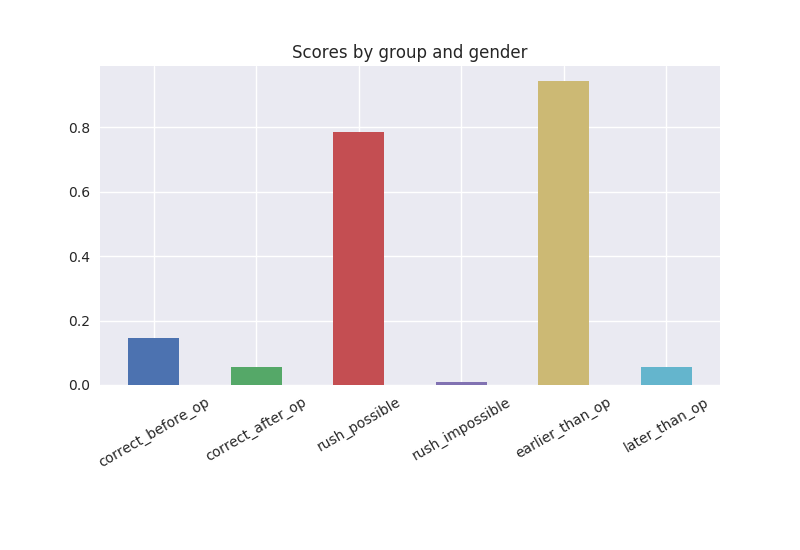

In [62]:
from IPython.display import Image
Image(filename='test.png') 